# Kuramoto in Complex Networks

- Vítor Fróis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings

from kuramoto import Kuramoto, plot_phase_coherence, plot_activity
from dataclasses import dataclass
from tqdm import tqdm
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

In [ ]:
n_nodes = 100
monte_carlo_iterations = 5
average_degree = 10

In [107]:
@dataclass
class NetworkSpec:
    name: str
    function: callable
    kwargs: dict

network_spec = [
    NetworkSpec(
        'barabasi_linear',
        nx.barabasi_albert_graph,
        kwargs={'n': n_nodes, 'm': int(average_degree/2)}
    ),
    NetworkSpec(
        'erdos_renyi',
        nx.erdos_renyi_graph,
        kwargs={'n': n_nodes, 'p': average_degree/(n_nodes-1)}
    ),
    NetworkSpec(
        'watts-strogatz',
        nx.watts_strogatz_graph, 
        kwargs={'n': n_nodes, 'k': average_degree, 'p': 0.1}
    )
]

In [ ]:
coupling_vals = np.linspace(0, 0.6, 100)

In [87]:
def plot_transition(spec: NetworkSpec):
    runs = []
    graph = spec.function(**spec.kwargs)

    adjacency_matrix = nx.to_numpy_array(graph)

    for coupling in coupling_vals:
        model = Kuramoto(coupling=coupling, dt=0.1, T=500, n_nodes=n_nodes)
        model.natfreqs = np.random.normal(1, 0.1, size=n_nodes)  # reset natural frequencies
        act_mat = model.run(adj_mat=adjacency_matrix)
        runs.append(act_mat)

    for i, coupling in enumerate(coupling_vals):
        r_mean = np.mean([model.phase_coherence(vec)
                        for vec in np.array(runs)[i, :, -1000:].T]) # mean over last 1000 steps
        plt.scatter(coupling, r_mean, c='steelblue', s=20, alpha=0.7)

    Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs) # analytical result (from paper)
    plt.vlines(Kc, 0, 1, linestyles='--', color='orange', label='analytical prediction')

    plt.legend()
    plt.grid(linestyle='--', alpha=0.8)
    plt.ylabel('order parameter (R)')
    plt.xlabel('coupling (K)')
    plt.title(f'Kuramoto in {spec.name}')
    sns.despine()

### Análise da Sincronização

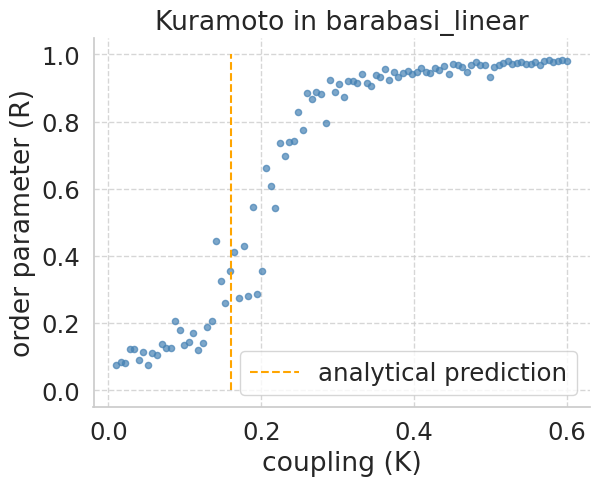

In [88]:
plot_transition(network_spec[0])

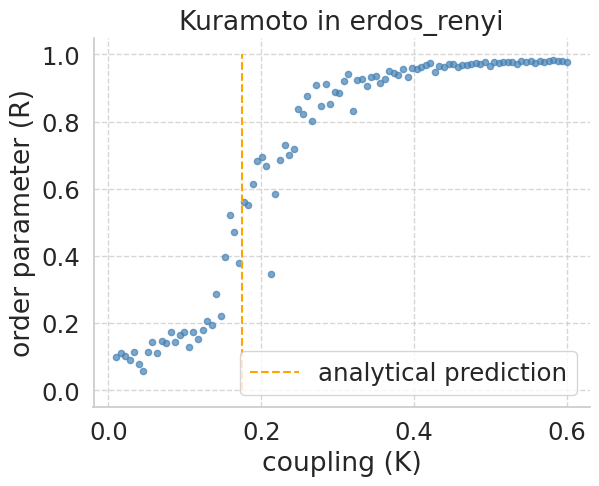

In [114]:
plot_transition(network_spec[1])

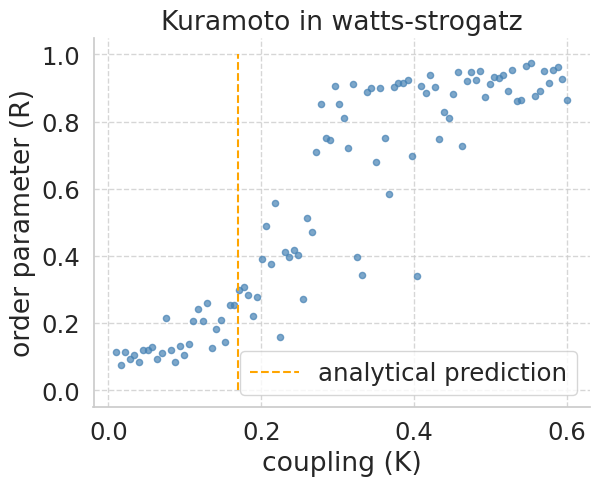

In [90]:
plot_transition(network_spec[2])

Geramos redes com $N=100$ nós e grau médio igual.

A rede Barabási-Álbert apresenta a menor dispersão entre os experimentos e uma transição de fase cedo. A rede Erdos Renyi apresenta transição de fase levemente mais cedo, também com baixa dispersão entre os experimentos. Ambas mostram alto potencial para sincronização. Já a rede Watts-Strogatz apresenta uma transição com $k$ maior, mostrando mais resistência a sincronização. Podemos interpretar que a alta clusterização diminui a sincronização

### Análise da rede Watts Strogatz para rewiring $p$ variável 

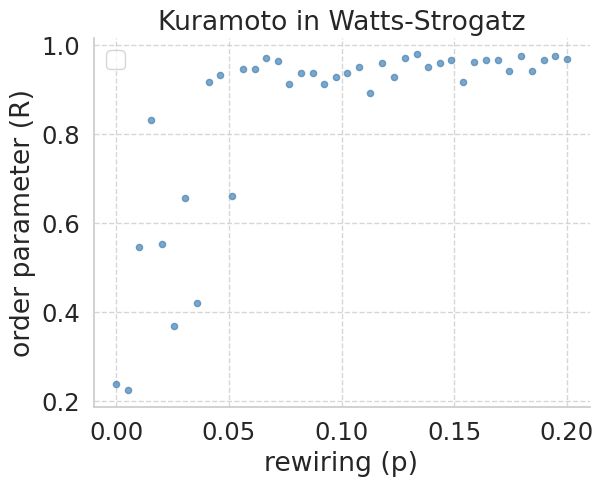

In [94]:
runs = []
p_values = np.linspace(0, 0.2, 40)

for p in p_values:
    graph = nx.watts_strogatz_graph(100, 10, p)

    adjacency_matrix = nx.to_numpy_array(graph)
    model = Kuramoto(coupling=coupling, dt=0.1, T=500, n_nodes=n_nodes)
    model.natfreqs = np.random.normal(1, 0.1, size=n_nodes)  # reset natural frequencies
    act_mat = model.run(adj_mat=adjacency_matrix)
    runs.append(act_mat)

for i, p in enumerate(p_values):
    r_mean = np.mean([model.phase_coherence(vec)
                    for vec in np.array(runs)[i, :, -1000:].T]) # mean over last 1000 steps
    plt.scatter(p, r_mean, c='steelblue', s=20, alpha=0.7)

plt.legend()
plt.grid(linestyle='--', alpha=0.8)
plt.ylabel('order parameter (R)')
plt.xlabel('rewiring (p)')
plt.title(f'Kuramoto in Watts-Strogatz')
sns.despine()

Podemos observar que há uma transição de fase para $p\approx 0.025$. Assim, apesar da alta clusterização, a característica de pequeno mundo auxilia na Sincronização